In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

# Desafío II - Redes convolucionales y recurrentes

En este segundo desafío vamos a aplicar los aprendido sobre redes convolucionales y recurrentes.
Tendremos en cuenta los siguientes aspectos:
Infraestructura y tiempos de entrenamiento de cada uno
Performance (medida en términos de accuracy)
Preprocesamiento.
Investigación general.
Parámetros ajustados y de hiperparámetros considerados.
Impacto de este modelo en la sociedad, o en la industria relevante.j

#Predicción de cotización del bitcoin utilizando redes recurrentes

 

Para comenzar, importamos algunas librerías necesarias para importar los valores históricos del bitcoin.

Partimos  de un baseline de rmse = 61.74 correspondiente a tomar el precio del bitcoin del día actual como válido para el día de mañana.

In [2]:
import os
import numpy as np
import pandas as pd


from google.colab import files
files.upload()

dfbit2 = pd.read_csv("bitcoin_price.csv", parse_dates=['Date'])

f = open("bitcoin_price.csv")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:] 

print(header)
print(len(lines))
print(lines)


Saving bitcoin_price.csv to bitcoin_price (1).csv


['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
1656
['Apr 28 2013,135.30,135.98,132.10,134.21,-,1500520000', 'Apr 29 2013,134.44,147.49,134.00,144.54,-,1491160000', 'Apr 30 2013,144.00,146.93,134.05,139.00,-,1597780000', 'May 01 2013,139.00,139.89,107.72,116.99,-,1542820000', 'May 02 2013,116.38,125.60,92.28,105.21,-,1292190000', 'May 03 2013,106.25,108.13,79.10,97.75,-,1180070000', 'May 04 2013,98.10,115.00,92.50,112.50,-,1089890000', 'May 05 2013,112.90,118.80,107.14,115.91,-,1254760000', 'May 06 2013,115.98,124.66,106.64,112.30,-,1289470000', 'May 07 2013,112.25,113.44,97.70,111.50,-,1248470000', 'May 08 2013,109.60,115.78,109.60,113.57,-,1219450000', 'May 09 2013,113.20,113.46,109.26,112.67,-,1259980000', 'May 10 2013,112.80,122.00,111.55,117.20,-,1255970000', 'May 11 2013,117.70,118.68,113.01,115.24,-,1311050000', 'May 12 2013,115.64,117.45,113.44,115.00,-,1288630000', 'May 13 2013,114.82,118.70,114.50,117.98,-,1279980000', 'May 14 2013,117.98,119.80,110.25,111.5

Mostramos el dataframe . Vamos a trabajar con columna "Close" correspondiente al valor de cierre del Bitcoin para cada día. 

Contamos con 1655 valores históricos de cierre, correspondientes a 1655 días entre Nov 07 2017 y Apr 28 2013.

In [3]:
dfbit2.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2013-04-28,135.30,135.98,132.10,134.21,-,1500520000
1,2013-04-29,134.44,147.49,134.00,144.54,-,1491160000
2,2013-04-30,144.00,146.93,134.05,139.00,-,1597780000
3,2013-05-01,139.00,139.89,107.72,116.99,-,1542820000
4,2013-05-02,116.38,125.60,92.28,105.21,-,1292190000


Graficamos los datos en orden cronológico.

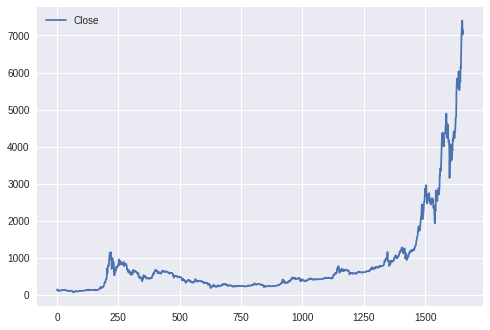

In [4]:
dfbit2.plot( y='Close')

In [0]:
float_data=dfbit2.iloc[:,4:5].values

## Preparando la data
La formulación exacta a nuestro problema será la siguiente: dados algunos puntos tan anteriores como lookback-timesteps (un timestep equivale a 1 día o 10 días) y tomando muestras cada steps timesteps, podemos predecir el valor del bitcoin en delay timesteps?

Usaremos los siguientes valores para los parámetros:

lookback = 10/1, nuestras observaciones se remiten a 10 días antes o 1 día antes.
steps = 1, nuestras observaciones serán sampleadas como un punto por día.
delay = 1, nuestros targets serán 24 horas en el futuro.

Utilizaremos el siguiente generador de Python:

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=10, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

Inicializamos tres generadores principales, uno de training, uno de validación y uno de testing.

In [0]:
lookback = 10
step = 1
delay = 1
batch_size = 1

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=1001,
                    max_index=1300,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1301,
                     max_index=None,
                     step=step,
                     batch_size=1)

predict_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1,
                     max_index=None,
                     step=1,
                     batch_size=1)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1600 - 1000 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 1600 - lookback) // batch_size

## Un enfoque básico de machine learning

El primer enforque que vamos aprobar es un modelo simple totalmente conectado. Comenzamos por aplanar los datos, luego lo ejecutamos a través de dos capas Dense. Probamos MAE  como la pérdida y MSE como métrica. Dado que estamos evaluando exactamente los mismos datos y con la misma métrica que con nuestro enfoque de sentido común, los resultados serán directamente comparables.

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=["mse"])
history = model.fit_generator(train_gen,
                              steps_per_epoch=16,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps
                             )

Epoch 1/20
16/16 [==============================] - 1s 53ms/step - loss: 351.4529 - mean_squared_error: 191647.7522 - val_loss: 453.8167 - val_mean_squared_error: 214564.2595
Epoch 2/20
16/16 [==============================] - 1s 47ms/step - loss: 210.4243 - mean_squared_error: 55374.8158 - val_loss: 161.4811 - val_mean_squared_error: 27750.5344
Epoch 3/20
16/16 [==============================] - 1s 48ms/step - loss: 52.0974 - mean_squared_error: 4662.5421 - val_loss: 25.8900 - val_mean_squared_error: 1301.3580
Epoch 4/20
16/16 [==============================] - 1s 50ms/step - loss: 23.5579 - mean_squared_error: 1823.1405 - val_loss: 29.1489 - val_mean_squared_error: 1345.4042
Epoch 5/20
16/16 [==============================] - 1s 51ms/step - loss: 11.9810 - mean_squared_error: 298.9032 - val_loss: 21.3801 - val_mean_squared_error: 938.8862
Epoch 6/20
16/16 [==============================] - 1s 64ms/step - loss: 35.1554 - mean_squared_error: 3888.2699 - val_loss: 17.7516 - val_mean_squ

Veamos las curvas de pérdida en validación y entrenamiento:

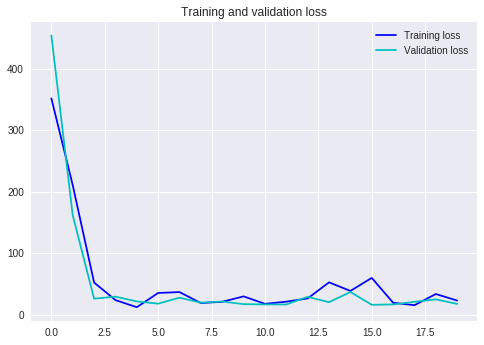

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

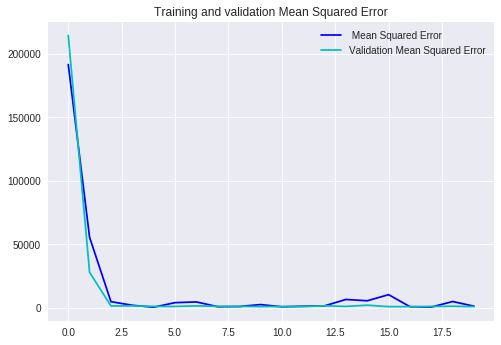

In [10]:
mean_squared_error = history.history['mean_squared_error']
val_mean_squared_error = history.history['val_mean_squared_error']

plt.plot(epochs, mean_squared_error, 'b', label=' Mean Squared Error')
plt.plot(epochs, val_mean_squared_error, 'c', label='Validation Mean Squared Error')
plt.title('Training and validation Mean Squared Error')
plt.legend()

plt.show()

In [11]:
dfbit2.iloc[:,4:5].head(10)


,Close
0,134.21
1,144.54
2,139.00
3,116.99
4,105.21
5,97.75
6,112.50
7,115.91
8,112.30
9,111.50


In [12]:
#Utilizamos el modelo para predecir los valores de test.
np.set_printoptions(threshold=np.inf)
prediccion = model.predict_generator(test_gen, steps=340, workers=1, use_multiprocessing=False, verbose=1)
prediccion

340/340 [==============================] - 0s 1ms/step


array([[ 732.3674 ],
       [ 729.4411 ],
       [ 732.21686],
       [ 734.8658 ],
       [ 741.29846],
       [ 746.38855],
       [ 753.1005 ],
       [ 757.7547 ],
       [ 762.6731 ],
       [ 763.63403],
       [ 759.471  ],
       [ 758.1674 ],
       [ 761.4336 ],
       [ 763.6533 ],
       [ 768.8483 ],
       [ 768.7186 ],
       [ 768.89954],
       [ 770.10956],
       [ 773.1459 ],
       [ 777.01   ],
       [ 777.7572 ],
       [ 778.35443],
       [ 783.38275],
       [ 794.53455],
       [ 806.341  ],
       [ 825.97766],
       [ 838.52026],
       [ 858.3781 ],
       [ 884.45   ],
       [ 900.73895],
       [ 912.62366],
       [ 913.38983],
       [ 921.4147 ],
       [ 947.20074],
       [ 966.8336 ],
       [ 975.096  ],
       [ 978.6976 ],
       [1012.61115],
       [1011.15765],
       [ 995.8805 ],
       [1006.7034 ],
       [ 994.90155],
       [ 951.3438 ],
       [ 902.16003],
       [ 854.17523],
       [ 880.1572 ],
       [ 873.5915 ],
       [ 833.

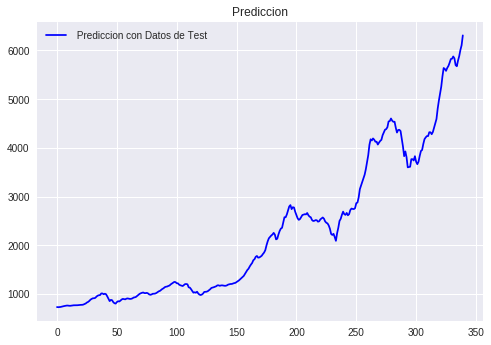

In [13]:
plt.plot(prediccion, 'b', label=' Prediccion con Datos de Test ')
plt.title('Prediccion')
plt.legend()

plt.show()

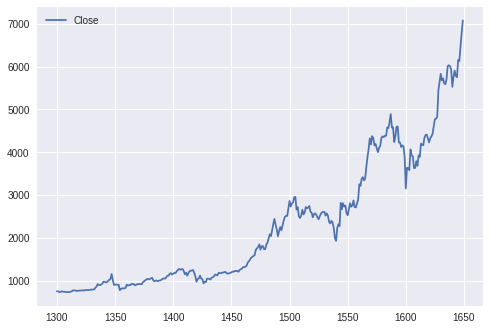

In [14]:
dfbit2.iloc[1300:1650,4:5].plot( y='Close')

Sorprendentemente este modelo simple supera el valor baseline con un MSE de 20,5 y entrenó en unos pocos segundos. Veremos si se justifica utilizar redes recurrentes.

## Modelo Recurrente Baseline

Usaremos la capa GRU, desarrollada por Cho et al. en 2014.

Las capas GRU (que significa "unidad recurrente cerrada") funcionan al aprovechar el mismo principio que LSTM, pero están algo optimizadas y, por lo tanto, son más económicas de ejecutar, aunque es posible que no tengan tanto poder de representación como LSTM.

Este trade-off entre el costo computacional y el poder de representación se ve en todas partes en el aprendizaje automático.


In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=16,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
16/16 [==============================] - 1s 76ms/step - loss: 316.3266 - mean_squared_error: 140581.5547 - val_loss: 547.6657 - val_mean_squared_error: 311840.0453
Epoch 2/10
16/16 [==============================] - 1s 52ms/step - loss: 295.8874 - mean_squared_error: 112792.6187 - val_loss: 550.8819 - val_mean_squared_error: 315236.6790
Epoch 3/10
16/16 [==============================] - 1s 51ms/step - loss: 280.7143 - mean_squared_error: 104554.5419 - val_loss: 552.0163 - val_mean_squared_error: 316649.7618
Epoch 4/10
16/16 [==============================] - 1s 52ms/step - loss: 316.2434 - mean_squared_error: 126087.2086 - val_loss: 551.5829 - val_mean_squared_error: 316183.9818
Epoch 5/10
16/16 [==============================] - 1s 52ms/step - loss: 321.9478 - mean_squared_error: 143376.7014 - val_loss: 549.4122 - val_mean_squared_error: 313534.2148
Epoch 6/10
16/16 [==============================] - 1s 51ms/step - loss: 381.3823 - mean_squared_error: 174237.6180 - val_los

Veamos los resultados:

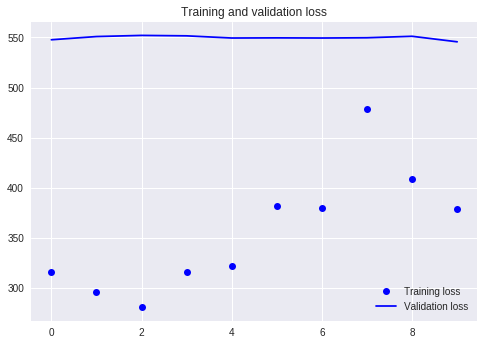

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

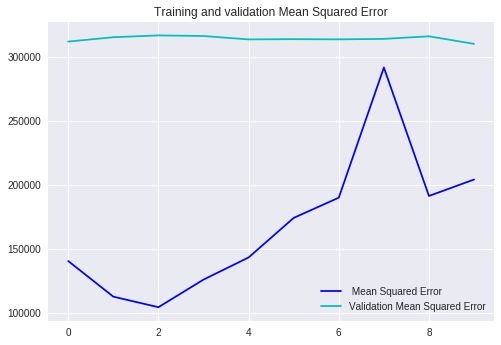

In [17]:
mean_squared_error = history.history['mean_squared_error']
val_mean_squared_error = history.history['val_mean_squared_error']

plt.plot(epochs, mean_squared_error, 'b', label=' Mean Squared Error')
plt.plot(epochs, val_mean_squared_error, 'c', label='Validation Mean Squared Error')
plt.title('Training and validation Mean Squared Error')
plt.legend()

plt.show()

Inclusive aumentando en la cantidad de neuronas, epochs y steps_per_epoch, obtenemos un resultado muy pobre. En este caso se observa un RMSE de 547,01.

## Usando recurrent dropout para  prevenir overfitting.




In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 2s 22ms/step - loss: 404.4300 - mean_squared_error: 205640.7203 - val_loss: 544.6894 - val_mean_squared_error: 308734.0471
Epoch 2/20
100/100 [==============================] - 2s 16ms/step - loss: 363.3384 - mean_squared_error: 168457.7135 - val_loss: 541.5021 - val_mean_squared_error: 305305.5091
Epoch 3/20
100/100 [==============================] - 2s 17ms/step - loss: 339.7938 - mean_squared_error: 156059.8590 - val_loss: 538.8528 - val_mean_squared_error: 302337.9400
Epoch 4/20
100/100 [==============================] - 2s 15ms/step - loss: 341.7276 - mean_squared_error: 161675.9847 - val_loss: 536.0835 - val_mean_squared_error: 299289.5940
Epoch 5/20
100/100 [==============================] - 1s 15ms/step - loss: 333.5817 - mean_squared_error: 147643.4089 - val_loss: 534.1849 - val_mean_squared_error: 297082.3183
Epoch 6/20
100/100 [==============================] - 2s 15ms/step - loss: 346.6918 - mean_squared_error: 160473.30

100/100 [==============================] - 1s 15ms/step - loss: 342.4200 - mean_squared_error: 151963.6738 - val_loss: 519.8204 - val_mean_squared_error: 281954.9757
Epoch 11/20
100/100 [==============================] - 1s 15ms/step - loss: 329.9210 - mean_squared_error: 142519.9440 - val_loss: 516.4359 - val_mean_squared_error: 278449.1028
Epoch 12/20
100/100 [==============================] - 1s 15ms/step - loss: 302.2117 - mean_squared_error: 130569.8676 - val_loss: 513.9908 - val_mean_squared_error: 276088.2219
Epoch 13/20
100/100 [==============================] - 1s 15ms/step - loss: 282.7063 - mean_squared_error: 111541.4524 - val_loss: 512.0515 - val_mean_squared_error: 274468.0437
Epoch 14/20
100/100 [==============================] - 1s 15ms/step - loss: 333.6700 - mean_squared_error: 142622.2574 - val_loss: 501.3742 - val_mean_squared_error: 263528.7840
Epoch 15/20
100/100 [==============================] - 1s 15ms/step - loss: 294.0043 - mean_squared_error: 124849.7814 - v

100/100 [==============================] - 1s 15ms/step - loss: 316.8492 - mean_squared_error: 143345.9187 - val_loss: 485.0162 - val_mean_squared_error: 246986.8164
Epoch 20/20
100/100 [==============================] - 1s 14ms/step - loss: 265.1592 - mean_squared_error: 111285.5327 - val_loss: 485.8389 - val_mean_squared_error: 248242.1183


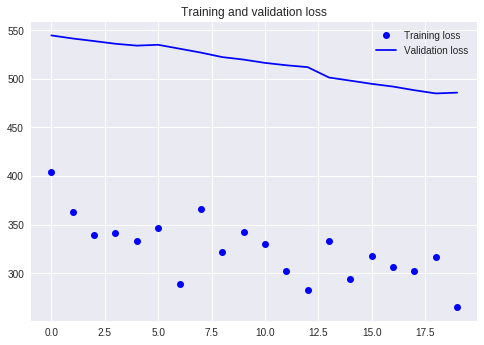

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Tras probar distintas cantidades de neuronas, epochs y steps_per_epochs logramos alcanzar un RMSE de 45,61. Mejor que el baseline pero peor que el modelo simple.

## Pila de Capas Recurrentes



In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/30
100/100 [==============================] - 4s 42ms/step - loss: 260.1478 - mean_squared_error: 119197.2549 - val_loss: 293.7564 - val_mean_squared_error: 98004.9479
Epoch 2/30
100/100 [==============================] - 3s 30ms/step - loss: 290.9821 - mean_squared_error: 172201.1121 - val_loss: 324.8990 - val_mean_squared_error: 116921.8127
Epoch 3/30
100/100 [==============================] - 3s 30ms/step - loss: 216.2194 - mean_squared_error: 83074.1056 - val_loss: 411.3530 - val_mean_squared_error: 180696.1366
Epoch 4/30
100/100 [==============================] - 3s 30ms/step - loss: 296.7734 - mean_squared_error: 182976.6765 - val_loss: 312.9437 - val_mean_squared_error: 109197.6557
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 276.5224 - mean_squared_error: 135423.5342 - val_loss: 313.7385 - val_mean_squared_error: 108924.6245
Epoch 6/30
100/100 [==============================] - 3s 30ms/step - loss: 245.3901 - mean_squared_error: 128036.6393

Epoch 7/30
100/100 [==============================] - 3s 29ms/step - loss: 243.0339 - mean_squared_error: 87553.9207 - val_loss: 401.4244 - val_mean_squared_error: 173271.1462
Epoch 8/30
100/100 [==============================] - 3s 29ms/step - loss: 247.5701 - mean_squared_error: 105841.0528 - val_loss: 460.3400 - val_mean_squared_error: 223585.5985
Epoch 9/30
100/100 [==============================] - 3s 29ms/step - loss: 284.1507 - mean_squared_error: 162010.7901 - val_loss: 407.9100 - val_mean_squared_error: 176961.4489
Epoch 10/30
100/100 [==============================] - 3s 28ms/step - loss: 260.6045 - mean_squared_error: 136680.0990 - val_loss: 391.2074 - val_mean_squared_error: 164735.6105
Epoch 11/30
100/100 [==============================] - 3s 27ms/step - loss: 248.9296 - mean_squared_error: 90137.3557 - val_loss: 431.4236 - val_mean_squared_error: 197369.9365
Epoch 12/30
100/100 [==============================] - 3s 28ms/step - loss: 270.1477 - mean_squared_error: 131181.2

100/100 [==============================] - 3s 28ms/step - loss: 319.8682 - mean_squared_error: 184441.7617 - val_loss: 446.7330 - val_mean_squared_error: 211416.6078
Epoch 14/30
100/100 [==============================] - 3s 28ms/step - loss: 295.8669 - mean_squared_error: 224320.5546 - val_loss: 435.0857 - val_mean_squared_error: 200856.0233
Epoch 15/30
100/100 [==============================] - 3s 28ms/step - loss: 271.3942 - mean_squared_error: 235080.4861 - val_loss: 343.6218 - val_mean_squared_error: 129406.3798
Epoch 16/30
100/100 [==============================] - 3s 28ms/step - loss: 287.6950 - mean_squared_error: 158037.9949 - val_loss: 379.6767 - val_mean_squared_error: 155541.1425
Epoch 17/30
100/100 [==============================] - 3s 28ms/step - loss: 262.9571 - mean_squared_error: 123047.3773 - val_loss: 384.4019 - val_mean_squared_error: 159015.5855
Epoch 18/30
100/100 [==============================] - 3s 28ms/step - loss: 267.3559 - mean_squared_error: 122231.4636 - v

100/100 [==============================] - 3s 29ms/step - loss: 325.4041 - mean_squared_error: 196677.1051 - val_loss: 311.8407 - val_mean_squared_error: 108323.0224
Epoch 20/30
100/100 [==============================] - 3s 29ms/step - loss: 329.1354 - mean_squared_error: 209493.6285 - val_loss: 315.8688 - val_mean_squared_error: 107824.2835
Epoch 21/30
100/100 [==============================] - 3s 28ms/step - loss: 273.9223 - mean_squared_error: 115763.2787 - val_loss: 420.2263 - val_mean_squared_error: 187513.8316
Epoch 22/30
100/100 [==============================] - 3s 28ms/step - loss: 291.5729 - mean_squared_error: 137141.7401 - val_loss: 465.9886 - val_mean_squared_error: 229043.5691
Epoch 23/30
100/100 [==============================] - 3s 31ms/step - loss: 285.1389 - mean_squared_error: 132277.5048 - val_loss: 368.2757 - val_mean_squared_error: 145699.9464
Epoch 24/30
100/100 [==============================] - 3s 30ms/step - loss: 274.6235 - mean_squared_error: 147942.2828 - v

100/100 [==============================] - 3s 30ms/step - loss: 288.5111 - mean_squared_error: 144241.4169 - val_loss: 463.4681 - val_mean_squared_error: 225837.4743
Epoch 26/30
100/100 [==============================] - 3s 30ms/step - loss: 316.9597 - mean_squared_error: 196377.1930 - val_loss: 447.8755 - val_mean_squared_error: 211881.8828
Epoch 27/30
100/100 [==============================] - 3s 30ms/step - loss: 243.8463 - mean_squared_error: 121944.9169 - val_loss: 92.5840 - val_mean_squared_error: 10226.9351
Epoch 28/30
100/100 [==============================] - 3s 31ms/step - loss: 264.6564 - mean_squared_error: 153015.9160 - val_loss: 497.6164 - val_mean_squared_error: 258940.0133
Epoch 29/30
100/100 [==============================] - 3s 30ms/step - loss: 275.6313 - mean_squared_error: 140880.4444 - val_loss: 418.5297 - val_mean_squared_error: 185838.6342
Epoch 30/30
100/100 [==============================] - 3s 30ms/step - loss: 289.7827 - mean_squared_error: 136278.4792 - val

Vamos los resultados:

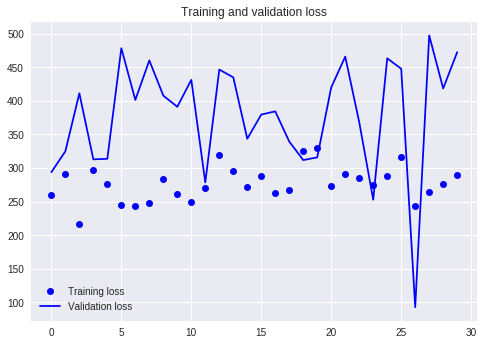

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Concluyendo



Sorprendentemente podemos concluir que de los modelos probados el más simple es el mejor y hasta lo que pudimos comprobar no se justifican los modelos de capas recurrentes.

